# Networks

In [1]:
#packages
import itertools, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.community as nx_comm
from tqdm.notebook import tqdm # for faster loop

FS = 15 # fontsize for plots 
CMAP = plt.get_cmap('hsv', lut=100) # cmap spectrum for plots

In [2]:
# defined functions
def draw_centrality(G, node_centrality, node_size=2000,
                    edge_centrality=None, edge_width=1,
                    cmap='Reds', font_color='white',
                    **kwargs):
    
    node_values = np.array([node_centrality[node] for node in G.nodes])
    if edge_centrality is None:
        edge_values = np.array([1 for edge in G.edges])
    else:
        edge_values = np.array([edge_centrality[edge] for edge in G.edges])
        
    plt.figure(figsize=(9,6))
    nx.draw(G, font_color=font_color,
            labels={node: np.round(node_centrality[node], 2) for node in G.nodes},
            node_size=node_size * node_values,
            node_color=node_values,
            width=edge_width * edge_values,
            vmin=np.min(node_values) - 0.3 * (np.max(node_values) - np.min(node_values)),
            # shift the bottom of the colormap so labels are visible
            cmap=cmap,
            **kwargs
           )
    return None
    
def get_degrees(graph):
    return [deg for _, deg in graph.degree()]

---
# Task 1. Zachary's karate club

A social network of a karate club was studied by Wayne W. Zachary for a period of three years from 1970 to 1972. The network captures 34 members of a karate club, documenting links between pairs of members who interacted outside the club. During the study a conflict arose between the administrator "John A" and instructor "Mr. Hi" (pseudonyms), which led to the split of the club into two. Half of the members formed a new club around Mr. Hi; members from the other part found a new instructor or gave up karate.

**a) Load data into a Graph object from the edgelist** ``data/zachary-karate.csv`` **using networkx**

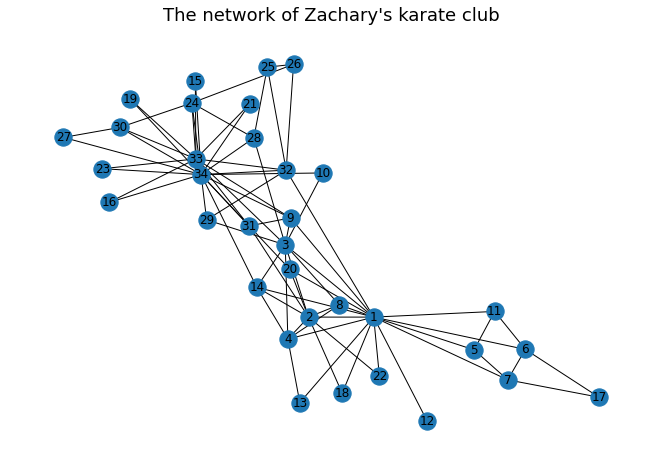

In [3]:
# Read the data
Graph_1 = nx.read_edgelist('data/zachary-karate.csv', delimiter=' ', comments='%')
# get positions
pos = nx.spring_layout(Graph_1, k=1, seed=137)
layout = nx.spring_layout(Graph_1)
# Draw the network
plt.figure(figsize=(9,6))
nx.draw(Graph_1, pos=layout, labels=None)
plt.title("The network of Zachary's karate club", fontsize=FS+3)
plt.show()

**b) Identify "John A" and "Mr. Hi" using appropriate centrality measures. Create a meaningful visualization.**

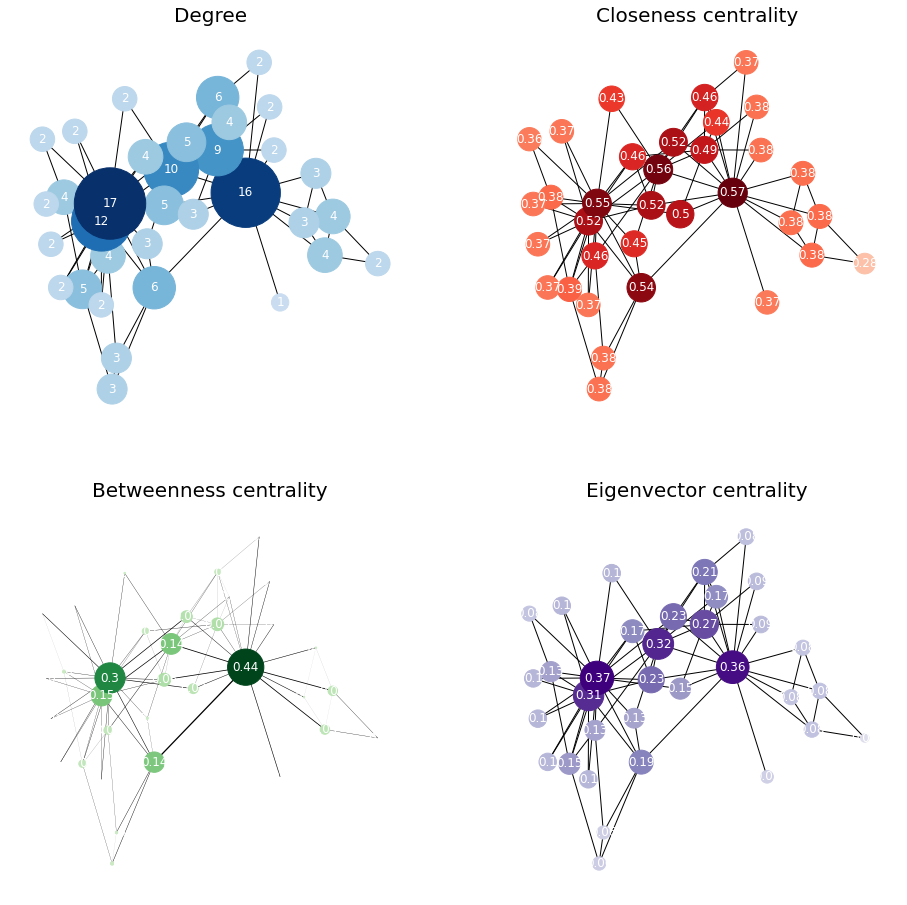

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 648x432 with 0 Axes>

In [4]:
# create example graph
layout = nx.spring_layout(Graph_1)

fig, axs = plt.subplots(2,2, figsize=(16,16))
# remove axis borders
for ax in axs.ravel():
    ax.axis('off')

#subplots
ax = axs[0,0]
ax.set_title('Degree', fontsize=20)
draw_centrality(Graph_1, Graph_1.degree(), pos=layout, ax=ax, node_size=300, cmap='Blues')
ax = axs[0,1]
ax.set_title('Closeness centrality', fontsize=20)
draw_centrality(Graph_1, nx.closeness_centrality(Graph_1), pos=layout, ax=ax, node_size=1500, cmap='Reds')
ax = axs[1,0]
ax.set_title('Betweenness centrality', fontsize=20)
edge_centrality = nx.edge_betweenness_centrality(Graph_1)
draw_centrality(Graph_1, nx.betweenness_centrality(Graph_1), pos=layout, ax=ax, node_size=3000, cmap='Greens', 
                edge_centrality=edge_centrality, edge_width=10)
ax = axs[1,1]
ax.set_title('Eigenvector centrality', fontsize=20)
draw_centrality(Graph_1, nx.eigenvector_centrality(Graph_1), node_size=3000, cmap='Purples', pos=layout, ax=ax)
plt.show()

In [5]:
sorted_dict = dict(sorted(Graph_1.degree(), key=lambda item: item[1], reverse=True))
identification = list(sorted_dict.keys())[:2]
print(f'"John A" and "Mr. Hi" must be the node with label {identification[0]} and {identification[1]}.  ')

"John A" and "Mr. Hi" must be the node with label 34 and 1.  


**c) Partition the graph iteratively using the Girvan-Newman algorithm. Visualize how the modularity changes as the number of communities grow. Visualize the community structure corresponding to maximal modularity.**
This method relies on the betweenness being high on edges connecting denser sub-regions. It iteratively removes the single edge with the highest betweenness (or the most valuable edge by some other metric), until the graph falls into 2, giving the first 2 communities. The procedure is continued until there are no edges left, i.e. every node is in its own community. Thankfully networkx wraps this procedure in a nice iterator.

networkx.org/[girvan_newman](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html)

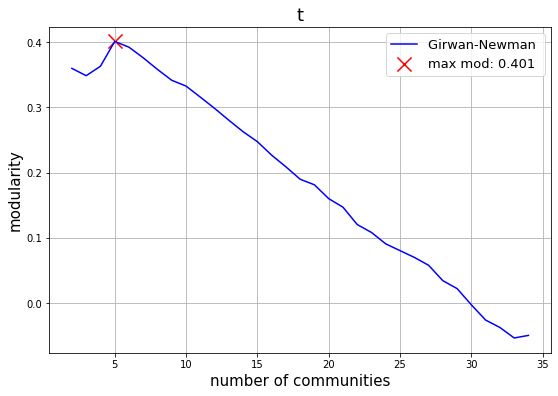

In [6]:
# create iterator
comm_iterator = nx_comm.girvan_newman(Graph_1)

modularities = []
n_comm = []
max_mod_comm = None
# iteration through girvan_newman algorithm
for communities in comm_iterator:
    modularity = nx_comm.modularity(Graph_1, communities)
    modularities.append(modularity)
    n_comm.append(len(communities))
    if max(modularities) == modularity:
        max_mod_comm = communities
# create a figure
plt.figure(figsize=(9,6))
plt.plot(n_comm, modularities, c='b', label='Girwan-Newman ')
plt.scatter(n_comm[np.argmax(modularities)], np.max(modularities), marker='x', s=200, c='r',
            label=f"max mod: {np.round(np.max(modularities),3)}")
plt.title("t", fontsize=FS+3)
plt.xlabel("number of communities", fontsize=FS)
plt.ylabel("modularity", fontsize=FS)
plt.legend(fontsize=FS-2)
plt.grid()
plt.show()

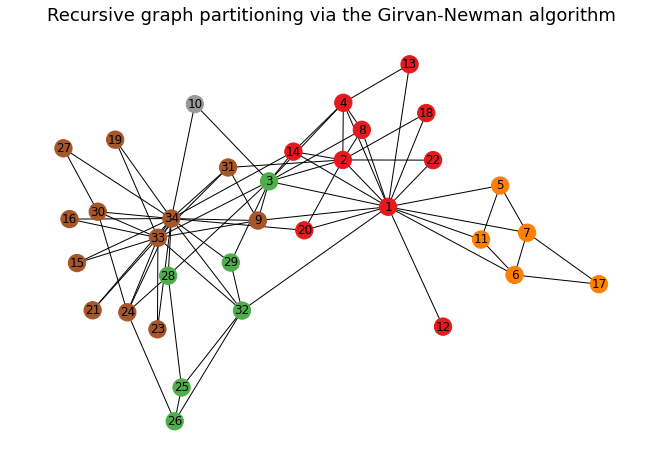

In [7]:
# create node partitioning
node2comm = {node: comm for comm, nodes in enumerate(max_mod_comm) for node in nodes}
#create figure
plt.figure(figsize=(9,6))
nx.draw(Graph_1, pos=layout, node_color=[node2comm[node] for node in Graph_1.nodes], labels=None, cmap='Set1')
plt.title("Recursive graph partitioning via the Girvan-Newman algorithm", fontsize=FS+3)
plt.show()

**d) Originally Zachary used the 'minimum cut' partitioning between "John A" and "Mr. Hi", and classified all members correctly (except one). How do these results compare to the previous excercise?**
Note that using the highest modularity partitioning doesn't always correspond to the best group structure for the given problem.

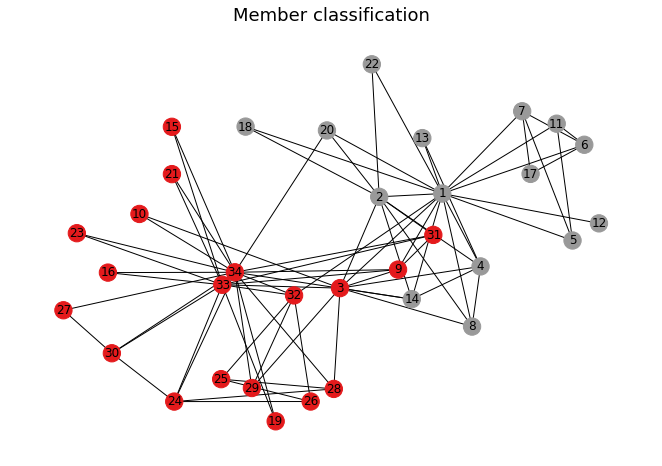

In [8]:
#classifying the member of the club 
nx.set_edge_attributes(Graph_1, 1, 'capacity')
_, min_cut_comm = nx.minimum_cut(Graph_1, identification[0], identification[1])

node2comm = {node: comm  for comm, nodes in enumerate(min_cut_comm) for node in nodes}

plt.figure(figsize=(9,6))
nx.draw(Graph_1, pos=pos, node_color=[node2comm[node] for node in Graph_1.nodes], labels=None, cmap='Set1')
plt.title("Member classification", fontsize=FS+3)
plt.show()

**BONUS**

**e) Create randomized counterparts for this graph using the configuration model. What changes compared to the original (regarding graph attributes, centrality measures or the optimal partitioning) and why?**
Creating randomized graphs while keeping key attributes of the original (e.g. the degrees in the configuration model) can help determine which characteristics are outstanding for such network. Comparing the original to the distribution of the randomized counterparts highlights unlikely structures which should not emerge randomly.\
Beware that the configuration model in networkx may create self-loops and multi-edges, which should not be possible in the original graph. Either discard them, or use the 'double-edge swap' approach (with the corresponding networkx function), where edges are iteratively swapped until the graph is sufficiently randomized (~10 times the number of edges swaps should be enough).

# Task 2. Random graph models

Random graph models aim to create graphs with well understood generation processes. By comparing real world networks to the ones generated by these models one might infer the rules behind their formation. 

**a) Create Erdős-Rényi random graphs of 10000 nodes and varying probability of connection (or number of edges). Plot how the degree distribution changes.**
The Erdős-Rényi model was the first and most basic random graph model: each of the $N$ nodes are connected with probability $p$ (or alternatively distribute $M$ edges between $N$ nodes, $p=\frac{2M}{N(N-1)}$). Most real world networks have significantly different structure (e.g. in degree distribution, clustering, group structure, but it still captures the "small-world" property).\
Note that the graph will consist of many separate subgaphs, unless $p \ge 1/N$ (or $M \ge N$).

In [9]:
N = 10000
probs = np.linspace(1/N, 10/N, 10)
ER_degrees, ER_hist = [], []
# create an Erdős-Rényi random graph
for p in tqdm(probs):
    degrees = get_degrees(nx.erdos_renyi_graph(N, p))
    ER_degrees.extend(degrees)
    ER_hist.append(np.histogram(degrees, bins=np.arange(max(degrees)+2), density=True))

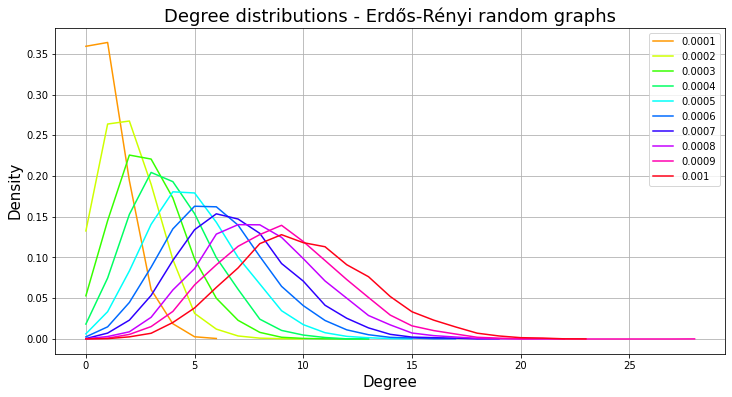

In [10]:
# density-degree distributions with different probability parameter
fig, ax = plt.subplots(figsize=(12,6))
for i, (hist, bins) in enumerate(ER_hist):
    ax.plot(bins[:-1], hist, color=CMAP(probs[i]/max(probs)), label=f"{np.round(probs[i], 5)}")
plt.title("Degree distributions - Erdős-Rényi random graphs", fontsize=FS+3)
plt.xlabel("Degree", fontsize=FS)
plt.ylabel("Density", fontsize=FS)
plt.legend()
plt.grid()
plt.show()

**b) Create Barabási-Albert random graphs of 10000 nodes with varying number of edges for new nodes. Plot how the degree distribution changes.**
The Barabási-Albert model is also known as preferential attachement. This network is iteratively grown by adding $N$ nodes one-by-one, each with $m$ new edge, which are connected to existing nodes preferentially: nodes with higher degree have proportionally higher chance of receiving a new edge. This leads to the "rich get richer" phenomena, where most nodes have low degrees, but a few hubs have really high. Interestingly this type of structure is much better suited to describe real world graphs, like the internet (both physical connections and virtual links), or social networks.\
When visualizing the degree distribution it is also worth using "log-log" plots (where powerlaws become linear).

In [11]:
arange_step = 2
m_edges = np.arange(2, 20, arange_step)
BA_degrees = []
BA_hist = []
BA_hist_logscale = []
# create an Barabási-Albert random graph and a log scaled random graph
for m in tqdm(m_edges):
    degrees = get_degrees(nx.barabasi_albert_graph(N, m))
    BA_degrees.append(degrees)
    BA_hist.append(np.histogram(degrees, bins=np.linspace(0, max(degrees), 100), density=True))
    bins = np.logspace(0, np.log(max(degrees))/np.log(arange_step), 100, base=arange_step)
    BA_hist_logscale.append(np.histogram(degrees, bins=bins, density=True))

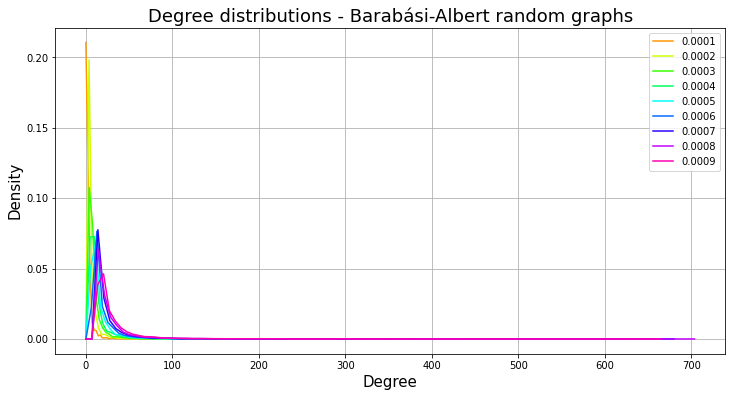

In [12]:
# density-degree distributions with different probability parameter
fig, ax = plt.subplots(figsize=(12,6))
for i, (hist, bins) in enumerate(BA_hist):
    ax.plot(bins[:-1], hist, color=CMAP(probs[i]/max(probs)), label=f"{np.round(probs[i], 5)}")
plt.title("Degree distributions - Barabási-Albert random graphs", fontsize=FS+3)
plt.xlabel("Degree", fontsize=FS)
plt.ylabel("Density", fontsize=FS)
plt.legend()
plt.grid()
plt.show()

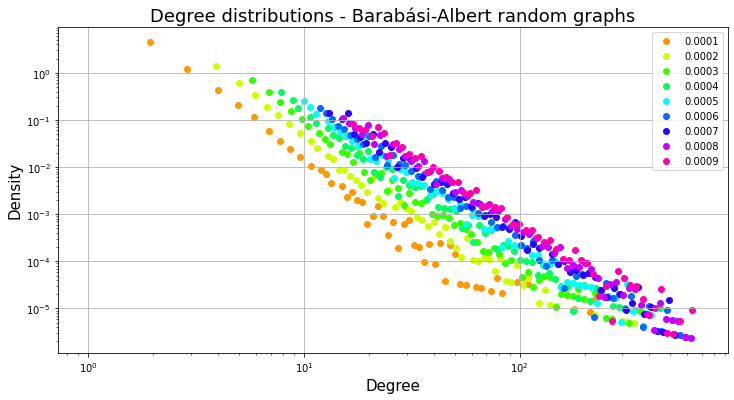

In [13]:
# density-degree distributions with different probability parameter - log-log scale
fig, ax = plt.subplots(figsize=(12,6))
for i, (hist, bins) in enumerate(BA_hist_logscale):
    ax.scatter(bins[:-1], hist, color=CMAP(probs[i]/max(probs)), label=f"{np.round(probs[i], 5)}")
    ax.set_xscale('log')
    ax.set_yscale('log')
plt.title("Degree distributions - Barabási-Albert random graphs", fontsize=FS+3)
plt.xlabel("Degree", fontsize=FS)
plt.ylabel("Density", fontsize=FS)
plt.legend()
plt.grid()
plt.show()

**c) Generate graphs with similar number of nodes and edges to Zachary's karate club using both models. Which degree distribution is closer to the original?**

In [14]:
n_graph = 1000
# nodes and edged of Zachary's graph
zachary_nodes = Graph_1.number_of_nodes()
zachary_edges = Graph_1.number_of_edges()

# create an E-R graph
ER_degs = []
for _ in tqdm(range(n_graph)):
    ER_degs.extend(get_degrees(nx.gnm_random_graph(zachary_nodes, zachary_edges)))
    
# create a B-A graph with different m values
BA_m2_degs = []
BA_m3_degs = []
BA_m4_degs = []
for _ in tqdm(range(n_graph)):
    BA_m2_degs.extend(get_degrees(nx.barabasi_albert_graph(zachary_nodes, m=2)))    
    BA_m3_degs.extend(get_degrees(nx.barabasi_albert_graph(zachary_nodes, m=3)))
    BA_m4_degs.extend(get_degrees(nx.barabasi_albert_graph(zachary_nodes, m=4)))

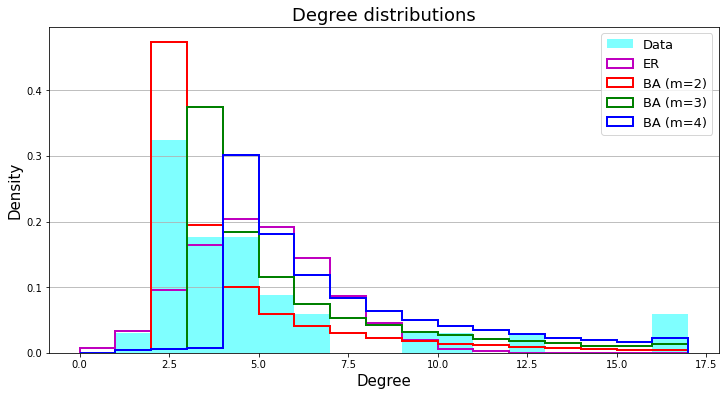

In [15]:
# Create a histogram of the distributions
karate_degs = get_degrees(Graph_1)
bins = np.arange(max(karate_degs)+1)

plt.figure(figsize=(12,6))
plt.hist(karate_degs, bins=bins, density=True, label='Data',  color='cyan', alpha=0.5)
plt.hist(ER_degs,    density=True, bins=bins, label='ER',       color='m', lw=2, histtype='step')
plt.hist(BA_m2_degs, density=True, bins=bins, label='BA (m=2)', color='r', lw=2, histtype='step')
plt.hist(BA_m3_degs, density=True, bins=bins, label='BA (m=3)', color='g', lw=2, histtype='step')
plt.hist(BA_m4_degs, density=True, bins=bins, label='BA (m=4)', color='b', lw=2, histtype='step')
plt.title("Degree distributions", fontsize=FS+3)
plt.xlabel("Degree", fontsize=FS)
plt.ylabel("Density", fontsize=FS)
plt.legend(fontsize=FS-2)
plt.grid(axis='y')
plt.show()

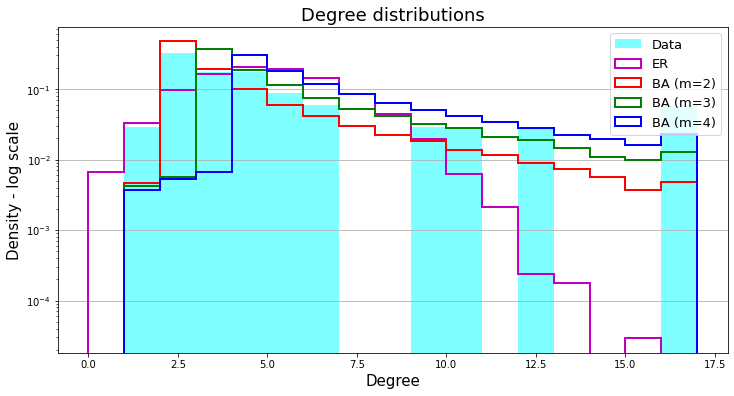

In [16]:
# log y-scale to show the cutoff of the distributions
plt.figure(figsize=(12,6))
plt.hist(karate_degs, bins=bins, density=True, label='Data',  color='cyan', alpha=0.5)
plt.hist(ER_degs,    density=True, bins=bins, label='ER',       color='m', lw=2, histtype='step')
plt.hist(BA_m2_degs, density=True, bins=bins, label='BA (m=2)', color='r', lw=2, histtype='step')
plt.hist(BA_m3_degs, density=True, bins=bins, label='BA (m=3)', color='g', lw=2, histtype='step')
plt.hist(BA_m4_degs, density=True, bins=bins, label='BA (m=4)', color='b', lw=2, histtype='step')
plt.title("Degree distributions", fontsize=FS+3)
plt.xlabel("Degree", fontsize=FS)
plt.ylabel("Density - log scale", fontsize=FS)
plt.yscale('log')
plt.legend(fontsize=FS-2)
plt.grid(axis='y')
plt.show()

The Erdős-Rényi distribution declines more rapidly, whereas the Barabási-Albert model aligns slightly better with the distribution.\
The Barabási-Albert model with a lower $m$ value fitting more better to the original data.

# Task 3. Large graph visualization  (academic collaboration)

**a) Load data into a Graph object from ``data/academic_collaboration.gpickle`` using networkx**
The .gpickle format allows storing node and edge attributes. In this example the universities (nodes) have their corresponding `country` and the collaborations (edges) have a `weight` attribute, representing collaboration strength.

In [17]:
# Read the pickle file
with open('data/academic_collaboration.gpickle', 'rb') as f:
    Graph_2 = pickle.load(f)
print(f"Number of nodes: {Graph_2.number_of_nodes()}, number of edges: {Graph_2.number_of_edges()}.")

Number of nodes: 3324, number of edges: 23335.


**b) Visualize the graph using its community structure.**\
This network is too large to be easily visualized with networkx. Find a community partition of the network, and create a meaningful visualization using these groups as nodes (e.g. node size as cluster size, edge width/opacity as mean or sum of collaboration strength, etc.). Also show the top few most prevalent countries in the communities, along with their prevalence (keep legibility, create a reference table in a separate cell if necessary).\
For community finding the *Girvan-Newman* algorithm would take too long (as it requires recalculating betweenness after each step), thus it is advised to use *Louvain* or *Infomap* algorithms.

[Louvain Community Detection Algorithm](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html)

In [18]:
# Louvain Community Detection Algorithm
communities = nx_comm.louvain_communities(Graph_2, weight='weight')
communities = sorted(communities, key=len, reverse=True)

### Create a pd dataframe from the graph's nodes
# Country column
df_nodes = pd.DataFrame(index=sorted(Graph_2.nodes))
df_nodes['country'] = pd.Series(nx.get_node_attributes(Graph_2, 'country'))
# Community column
for i, comm in enumerate(communities):
    df_nodes.loc[list(comm), 'community'] = i
# count the number of country for each community
df_comm = df_nodes.groupby('community').count().rename(columns={'country': 'size'})
def calculate_country_percentage(df):
    # define a function to calculate the percentage of each country in a community
    country_counts = df.value_counts()
    top_countries = country_counts[:3]
    # calculate percentage for each country and format it
    formatted_string = [f"{country} ({round(cnt/len(df), 2)})" for country, cnt in top_countries.items()]
    return ", ".join(formatted_string)
# group df_nodes by community and apply the above function 
df_comm['countries'] = df_nodes.groupby('community')['country'].apply(calculate_country_percentage)
# show the final dataframe
df_comm

,size,countries
community,,
0.0,668,"Russia (0.23), Italy (0.11), Poland (0.1)"
1.0,524,"India (0.26), Indonesia (0.1), Malaysia (0.09)"
2.0,325,"Brazil (0.27), Mexico (0.21), Argentina (0.12)"
3.0,315,"China (0.92), Singapore (0.03), Hong Kong (0.03)"
4.0,270,"United Kingdom (0.57), Netherlands (0.1), Irel..."
5.0,228,"United States (0.97), United Arab Emirates (0...."
6.0,160,"France (0.81), Lebanon (0.09), Germany (0.05)"
7.0,144,"Spain (0.76), Portugal (0.13), Cuba (0.04)"
8.0,125,"Germany (0.64), Austria (0.18), Switzerland (0..."


In [19]:
# create a graph for the visuaization
Graph_3 = nx.Graph()
Graph_3.add_nodes_from([(node, attr) for node, attr in df_comm.to_dict('index').items()])

# iterate through all pairs of communities.
for c1, c2 in itertools.combinations(df_comm.index, 2):
    nodes1 = df_nodes.index[df_nodes['community'] == c1]
    nodes2 = df_nodes.index[df_nodes['community'] == c2]
    # calculate edge weights
    edge_weights = [w for src, tgt, w in nx.edge_boundary(Graph_2, nodes1, nodes2, data='weight')]
    # add an edge between the two communities
    Graph_3.add_edge(c1, c2, sum_weight=sum(edge_weights))

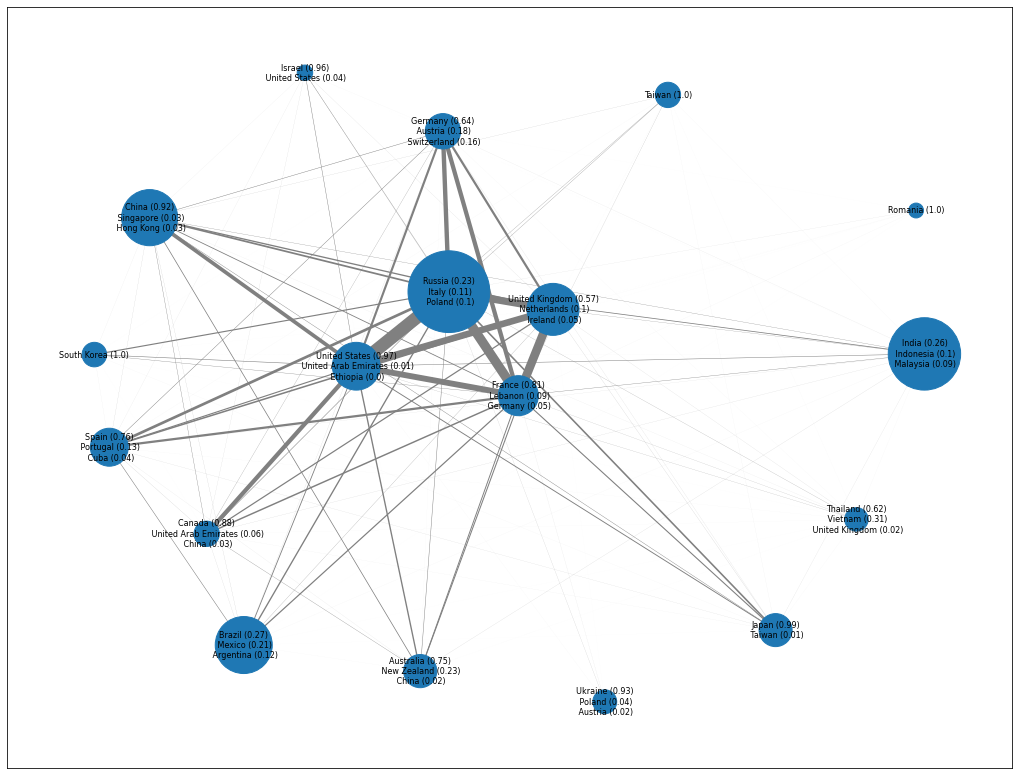

In [20]:
# create the figure
fig, ax = plt.subplots(figsize=(18, 14))
pos = nx.spring_layout(Graph_3, weight='sum_weight', k=8, seed=42) 
# Nodes
nx.draw_networkx_nodes(Graph_3, ax=ax, pos=pos, node_size=[size*10 for node, size in Graph_3.nodes(data='size')])
# Labels
nx.draw_networkx_labels(Graph_3, ax=ax, pos=pos, font_size=8, 
                labels={node: countries.replace(',', '\n') for node, countries in Graph_3.nodes(data='countries')},)
# Edges
nx.draw_networkx_edges(Graph_3, ax=ax, pos=pos, edge_color='gray', 
                       width=[Graph_3.edges[edge]['sum_weight']/30 for edge in Graph_3.edges])
plt.show()

# Task 4. Infection process

**Analyze how an infection spreads in Erdős-Rényi and Barabási-Albert random graphs. Measure the speed of the process and try to explain the results.**
Generate graphs of 10000 nodes and similar density with both models (you can also create several graphs for more robust results). Simulate a simple infection spreading process where each infected node infects all its susceptible (not yet infected) neighbors. Initiate with a few random infected nodes and measure how fast the infection spreads (e.g. how long it takes to reach X% infected). Try to explain the results (btw the B-A. model describes our social structure much better...).

In [21]:
def infection(graph, time, start_nodes=[]):
    # create the adjacency matrix
    adj = nx.to_numpy_array(graph)
    # get the infected nodes (if these exist)
    infected = np.array([node in start_nodes for node in graph.nodes()])
    history = [infected]
    for t in range(time):
        # with a dot product we can find the following stage
        # and maximalize the infected nodes
        infected = np.minimum(adj.dot(infected), 1)
        # store the data
        history.append(infected)
    return np.array(history)

In [22]:
N = 10000 # nodes
T = 10 # time
k = 20 # number of random set
BA_params = [2,3,4,5] # different parameters for Barabási-Albert model
BA_result = {}
for m in tqdm(BA_params):
    inf_percent_histories = []
    for _ in range(k):
        # infected nodes
        start_nodes = np.random.randint(N, size=2)
        # infection history
        inf_history = infection(nx.barabasi_albert_graph(N, m), T, start_nodes) 
        inf_percent_histories.append(inf_history.mean(axis=1))
    # store the data
    BA_result[m] = np.mean(np.array(inf_percent_histories), axis=0)

In [23]:
ER_params = N*np.array(BA_params) # different parameters for Erdős-Rényi model
ER_result = {}
for m in tqdm(ER_params):
    inf_percent_histories = []
    for _ in range(k):
        # infected nodes
        start_nodes = np.random.randint(N, size=2)
        # infection history
        inf_history = infection(nx.gnm_random_graph(N, m), T, start_nodes) 
        inf_percent_histories.append(inf_history.mean(axis=1))
    # store the data
    ER_result[m] = np.mean(np.array(inf_percent_histories), axis=0)

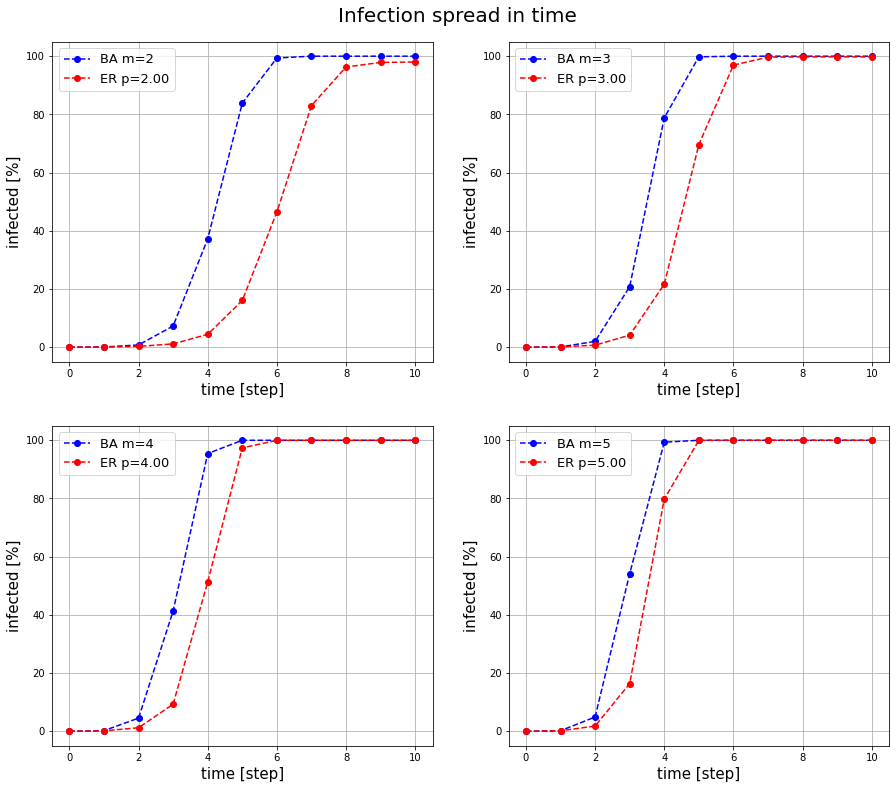

In [24]:
# Create figure
fig, axs = plt.subplots(2,2, figsize=(15,12))
for i, (m, inf_percentages) in enumerate(BA_result.items()):
    axs.ravel()[i].plot(inf_percentages*100, 'o--', label=f"BA m={m}", color='b')
for i, (m, inf_percentages) in enumerate(ER_result.items()):
    axs.ravel()[i].plot(inf_percentages*100, 'o--', label=f"ER p={m/N:.2f}", color='r')  
    axs.ravel()[i].set_ylabel("infected [%]", fontsize=FS)
    axs.ravel()[i].set_xlabel("time [step]", fontsize=FS)
    axs.ravel()[i].legend(fontsize=FS-2)
    axs.ravel()[i].grid()
fig.suptitle('Infection spread in time', fontsize=FS+5)
plt.subplots_adjust(top=0.94)
plt.show()

In the Erdős-Rényi model, the spread of infection among nodes is slower due to the absence of small-world properties, whereas the Barabási-Albert model exhibits such properties, leading to a faster spread.